Label file: /home/jinjinjara1022/AutonomousDriving/datasets/tusimple/TUSimple/test_label.json
Using image: /home/jinjinjara1022/AutonomousDriving/datasets/tusimple/TUSimple/test_set/clips/0531/1492636854007591530/5.jpg


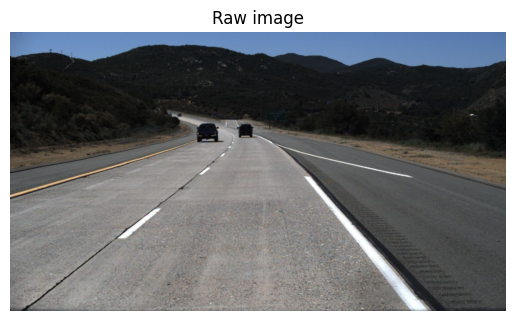

In [ ]:
# 0) Imports & 기본 경로
import json
from pathlib import Path
import cv2
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

# 데이터 경로 (사용자 환경 맞춤)
BASE_DIR = Path("/home/jinjinjara1022/AutonomousDriving/datasets/tusimple")
ALT_DIR  = BASE_DIR / "TUSimple"   

# 라벨 파일(선택)
label_paths = [
    ALT_DIR / "test_label.json", 
    ALT_DIR / "test_label_new.json",
    BASE_DIR / "test_label.json",
    BASE_DIR / "test_label_new.json"
]
label_path = next((p for p in label_paths if p.exists()), None)
print("Label file:", label_path)

# 라벨이 있으면 첫 샘플 파일 경로 얻고, 없으면 수동으로 지정
def resolve_image_path(raw_file:str):
    p1 = BASE_DIR / raw_file
    p2 = ALT_DIR / raw_file
    if p1.exists(): return p1
    if p2.exists(): return p2
    return None

def load_sample_image():
    # 라벨에서 이미지 경로 찾기
    if label_path is not None:
        with open(label_path, "r") as f:
            for line in f:
                sample = json.loads(line)
                img_path = resolve_image_path(sample["raw_file"])
                if img_path is not None and img_path.exists():
                    return str(img_path), sample
    # 실패 시: 직접 경로 지정 (원하면 바꾸세요)
    fallback = next(ALT_DIR.rglob("*.jpg"), None) or next(BASE_DIR.rglob("*.jpg"), None)
    return (str(fallback), None) if fallback else (None, None)

img_path, sample = load_sample_image()
assert img_path is not None, "TuSimple 이미지 파일을 찾지 못했습니다. 경로를 확인하세요."
print("Using image:", img_path)

img_bgr = cv2.imread(img_path)
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

plt.imshow(img_rgb); plt.title("Raw image"); plt.axis("off"); plt.show()

In [78]:
# 1) 초간단 차선검출 함수 (Canny + ROI + HoughLinesP)
def simple_lane_detect(img_bgr,
                       canny_low=50, canny_high=150,
                       roi_top=0.60, roi_left=0.08, roi_right=0.92,
                       hough_rho=1, hough_theta=np.pi/180, hough_thresh=30,
                       min_line_len=40, max_line_gap=80,
                       slope_min=0.2,   # 너무 수평인 선 제거
                       length_min=30):  # 너무 짧은 선 제거
    img = img_bgr.copy()
    h, w = img.shape[:2]

    # 1) Canny
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    blur = cv2.GaussianBlur(gray, (5,5), 0)
    edges = cv2.Canny(blur, canny_low, canny_high)

    # 2) ROI (하단 트래피조이드 마스크)
    mask = np.zeros_like(edges)
    poly = np.array([[(int(roi_left*w), h),
                      (int(0.5*w), int(roi_top*h)),
                      (int(roi_right*w), h)]], dtype=np.int32)
    cv2.fillPoly(mask, poly, 255)
    masked = cv2.bitwise_and(edges, mask)

    # 3) HoughLinesP
    lines = cv2.HoughLinesP(masked, hough_rho, hough_theta, hough_thresh,
                            minLineLength=min_line_len, maxLineGap=max_line_gap)

    out = img.copy()
    if lines is not None:
        for l in lines[:,0]:
            x1, y1, x2, y2 = l
            dx, dy = (x2-x1), (y2-y1)
            length = np.hypot(dx, dy)
            slope = abs(dy / dx) if dx != 0 else 999.0
            if length < length_min: 
                continue
            if slope < slope_min: 
                continue
            # 차선 후보 그리기
            cv2.line(out, (x1,y1), (x2,y2), (0,255,0), 3)
    return edges, masked, out

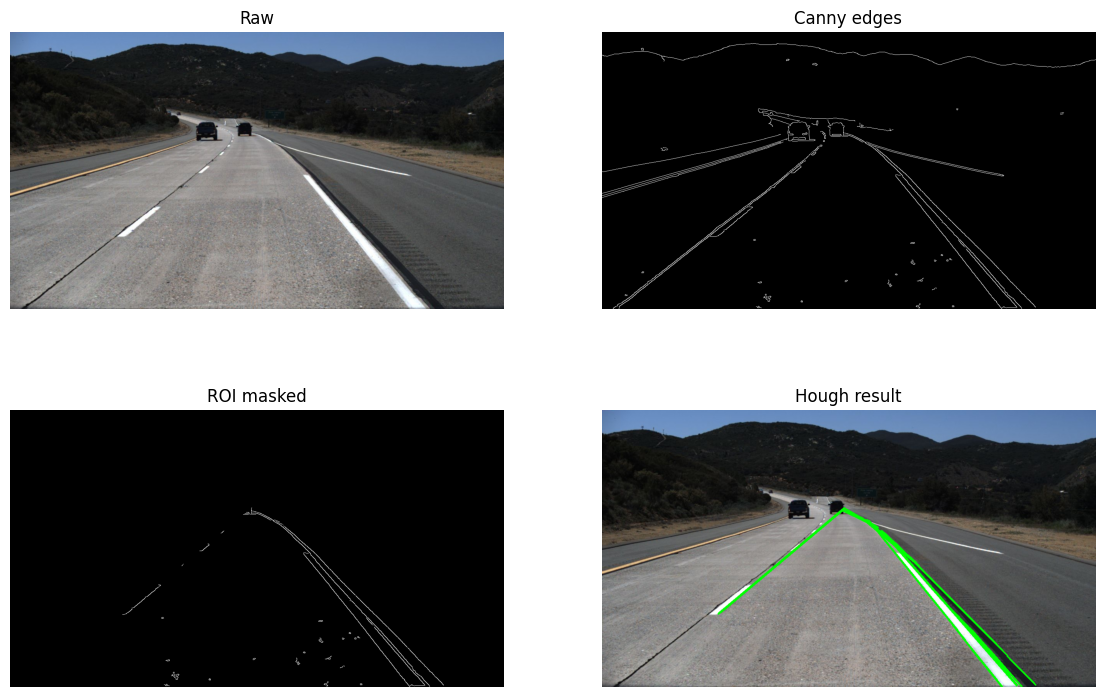

In [95]:
# 2) 실행 & 시각화
edges, masked, out = simple_lane_detect(img_bgr,
                                        canny_low=60, canny_high=160,
                                        roi_top=0.34, roi_left=0.05, roi_right=0.95,
                                        hough_thresh=25, min_line_len=50, max_line_gap=120,
                                        slope_min=0.35, length_min=40)

plt.figure(figsize=(14,9))
plt.subplot(2,2,1); plt.title("Raw"); plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)); plt.axis("off")
plt.subplot(2,2,2); plt.title("Canny edges"); plt.imshow(edges, cmap="gray"); plt.axis("off")
plt.subplot(2,2,3); plt.title("ROI masked"); plt.imshow(masked, cmap="gray"); plt.axis("off")
plt.subplot(2,2,4); plt.title("Hough result"); plt.imshow(cv2.cvtColor(out, cv2.COLOR_BGR2RGB)); plt.axis("off")
plt.show()


In [96]:
def simple_lane_detect(img_bgr,
                       canny_low=50, canny_high=150,
                       roi_top=0.65, roi_left=0.05, roi_right=0.95,
                       hough_rho=1, hough_theta=np.pi/180, hough_thresh=20,
                       min_line_len=40, max_line_gap=150,
                       slope_min=0.35, length_min=30):
    import cv2, numpy as np
    img = img_bgr.copy()
    h, w = img.shape[:2]

    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    blur = cv2.GaussianBlur(gray, (3,3), 0)
    edges = cv2.Canny(blur, canny_low, canny_high)

    mask = np.zeros_like(edges)
    poly = np.array([[(int(roi_left*w), h),
                      (int(0.5*w), int(roi_top*h)),
                      (int(roi_right*w), h)]], dtype=np.int32)
    cv2.fillPoly(mask, poly, 255)
    masked = cv2.bitwise_and(edges, mask)

    lines = cv2.HoughLinesP(masked, hough_rho, hough_theta, hough_thresh,
                            minLineLength=min_line_len, maxLineGap=max_line_gap)

    out = img.copy()
    if lines is not None:
        for x1,y1,x2,y2 in lines[:,0]:
            dx, dy = (x2-x1), (y2-y1)
            length = (dx*dx + dy*dy) ** 0.5
            slope  = abs(dy/dx) if dx!=0 else 999
            if length < length_min or slope < slope_min:
                continue
            cv2.line(out, (x1,y1), (x2,y2), (0,255,0), 3)
    return out  # 👈 한 장만 반환


In [102]:
import re, glob

def numeric_sort_key(p: Path):
    # 파일명에 있는 숫자 추출해서 정렬 (0.jpg, 1.jpg, 2.jpg …)
    m = re.search(r'(\d+)', p.stem)
    return int(m.group(1)) if m else p.stem

def process_tusimple_clip(clip_dir, output_path="tusimple_lane_demo.mp4", fps=20):
    clip_dir = Path(clip_dir)
    imgs = sorted([Path(p) for p in glob.glob(str(clip_dir/"*.jpg"))], key=numeric_sort_key)
    assert len(imgs) > 0, f"이미지 없음: {clip_dir}"

    # 첫 프레임 크기
    first = cv2.imread(str(imgs[0]))
    h, w = first.shape[:2]

    fourcc = cv2.VideoWriter_fourcc(*"mp4v")
    writer = cv2.VideoWriter(output_path, fourcc, fps, (w, h))
    assert writer.isOpened(), f"VideoWriter 생성 실패: {output_path}"

    for i, img_path in enumerate(imgs):
        frame = cv2.imread(str(img_path))
        out = simple_lane_detect(img_bgr=frame,
                                        canny_low=60, canny_high=160,
                                        roi_top=0.34, roi_left=0.05, roi_right=0.95,
                                        hough_thresh=25, min_line_len=50, max_line_gap=120,
                                        slope_min=0.35, length_min=40)
        writer.write(out)
        if (i+1) % 100 == 0:
            print(f"{i+1}/{len(imgs)} 프레임 처리")

    writer.release()
    print(f"저장 완료: {output_path}")

In [103]:
process_tusimple_clip("/home/jinjinjara1022/AutonomousDriving/datasets/tusimple/TUSimple/test_set/clips/0530/1492626760788443246_0",
                      "tusimple_clip_result.mp4", fps=20)

저장 완료: tusimple_clip_result.mp4
